In [6]:
# Cargar datos

import os
import pandas as pd
import numpy as np
from pathlib import Path

print("CWD:", os.getcwd())

if Path("data/raw").exists():
    DATA_RAW = Path("data/raw")
elif Path("../data/raw").exists():
    DATA_RAW = Path("../data/raw")
else:
    raise FileNotFoundError("No encuentro data/raw ni ../data/raw. Verifica tu estructura de carpetas.")

DATA_PROCESSED = (Path("data/processed") if Path("data").exists() else Path("../data/processed"))
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

sales_path = DATA_RAW / "sales_train.csv"
test_path  = DATA_RAW / "test.csv"
items_path = DATA_RAW / "items_en.csv"

print("DATA_RAW:", DATA_RAW.resolve())
print("sales_train exists?", sales_path.exists(), sales_path.resolve())
print("test exists?",        test_path.exists(),  test_path.resolve())
print("items exists?",       items_path.exists(), items_path.resolve())


CWD: /Users/andrespadronquintana/Desktop/METODOS_GRAN_ESCALA/TAREAS/tarea1_future_sales
DATA_RAW: /Users/andrespadronquintana/Desktop/METODOS_GRAN_ESCALA/TAREAS/tarea1_future_sales/data/raw
sales_train exists? True /Users/andrespadronquintana/Desktop/METODOS_GRAN_ESCALA/TAREAS/tarea1_future_sales/data/raw/sales_train.csv
test exists? True /Users/andrespadronquintana/Desktop/METODOS_GRAN_ESCALA/TAREAS/tarea1_future_sales/data/raw/test.csv
items exists? True /Users/andrespadronquintana/Desktop/METODOS_GRAN_ESCALA/TAREAS/tarea1_future_sales/data/raw/items_en.csv


In [7]:
# Construimos las ventas mensuales

sales = pd.read_csv(sales_path)
test  = pd.read_csv(test_path)
items = pd.read_csv(items_path)

sales["date"] = pd.to_datetime(sales["date"], format="%d.%m.%Y", errors="coerce")
sales["item_cnt_day"] = sales["item_cnt_day"].clip(0, 20)

monthly = (sales
           .groupby(["date_block_num","shop_id","item_id"], as_index=False)
           .agg(item_cnt_month=("item_cnt_day","sum"),
                item_price_mean=("item_price","mean")))

monthly["item_cnt_month"] = monthly["item_cnt_month"].clip(0, 20)
monthly["item_price_mean"] = monthly["item_price_mean"].fillna(0).astype(np.float32)

monthly.head()


,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean
0,0,0,32,6.0,221.0
1,0,0,33,3.0,347.0
2,0,0,35,1.0,247.0
3,0,0,43,1.0,221.0
4,0,0,51,2.0,128.5


Estamos transformando ventas diarias (sales_train) en una tabla mensual (monthly) con el target item_cnt_month que el modelo va a aprender y luego vamos a crear “lags” (ventas del mes anterior, etc.) para predecir el mes 34.

In [12]:
# Parte del EDA (1.1) 
# Tamaño, rango temporal, tiendas y productos

print("Sales rows:", sales.shape)
print("Monthly rows:", monthly.shape)

print("Meses (date_block_num):", monthly["date_block_num"].min(), "a", monthly["date_block_num"].max())
print("Tiendas únicas:", monthly["shop_id"].nunique())
print("Productos únicos:", monthly["item_id"].nunique())

monthly["item_cnt_month"].describe()

Sales rows: (2935849, 6)
Monthly rows: (1609124, 5)
Meses (date_block_num): 0 a 33
Tiendas únicas: 60
Productos únicos: 21807


count    1.609124e+06
mean     2.026762e+00
std      2.578918e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.000000e+01
Name: item_cnt_month, dtype: float64

In [8]:
# Construímos pares y grids

# 1) Pares (shop_id, item_id) relevantes:
#    - observados en train (monthly)
#    - y los del test (Kaggle)
observed_pairs = monthly[["shop_id", "item_id"]].drop_duplicates()
test_pairs = test[["shop_id", "item_id"]].drop_duplicates()
pairs = pd.concat([observed_pairs, test_pairs], ignore_index=True).drop_duplicates()

# 2) Grid mensual para train: meses 0..33
grid_train = (pd.MultiIndex.from_product(
    [range(0, 34), pairs["shop_id"].unique(), pairs["item_id"].unique()],
    names=["date_block_num", "shop_id", "item_id"]
).to_frame(index=False))

# Reducir a pares válidos (misma lista "pairs")
grid_train = (grid_train
              .merge(pairs.assign(ok=1), on=["shop_id","item_id"], how="inner")
              .drop(columns="ok"))

# 3) Grid del test como mes 34 (solo pares del test)
grid_test = test_pairs.copy()
grid_test["date_block_num"] = 34

print("grid_train shape:", grid_train.shape)
print("grid_test  shape:", grid_test.shape)
grid_train.head()


grid_train shape: (17915280, 3)
grid_test  shape: (214200, 3)


,date_block_num,shop_id,item_id
0,0,0,32
1,0,0,33
2,0,0,35
3,0,0,43
4,0,0,51


- Train: todas las combinaciones (mes 0..33, tienda, producto) relevantes.

- Test: mismas columnas pero solo mes 34 y pares del test.

In [9]:
# Merge del target

# Train: merge del target mensual
train = grid_train.merge(monthly, on=["date_block_num","shop_id","item_id"], how="left")

# donde no hubo ventas ese mes -> 0
train["item_cnt_month"] = train["item_cnt_month"].fillna(0).astype(np.float32)
train["item_price_mean"] = train["item_price_mean"].fillna(0).astype(np.float32)

# agregar categoría del item
train = train.merge(items[["item_id","item_category_id"]], on="item_id", how="left")
train["item_category_id"] = train["item_category_id"].fillna(-1).astype(np.int16)

print("train shape:", train.shape)
train.head()


train shape: (17915280, 6)


,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,item_category_id
0,0,0,32,6.0,221.0,40
1,0,0,33,3.0,347.0,37
2,0,0,35,1.0,247.0,40
3,0,0,43,1.0,221.0,40
4,0,0,51,2.0,128.5,57


In [13]:
# Parte del EDA (1.2) 

zero_rate = (train["item_cnt_month"] == 0).mean()
print(f"% de meses con 0 ventas (sparsity): {100*zero_rate:.2f}%")


% de meses con 0 ventas (sparsity): 91.02%


Matplotlib is building the font cache; this may take a moment.


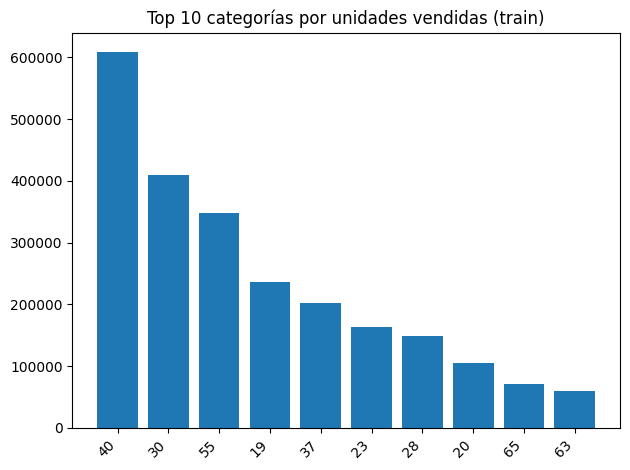

In [15]:
# Parte del EDA (1.3) 

top_cats = (train.groupby("item_category_id", as_index=False)["item_cnt_month"]
            .sum()
            .sort_values("item_cnt_month", ascending=False)
            .head(10))

top_cats

import matplotlib.pyplot as plt

plt.figure()
plt.bar(top_cats["item_category_id"].astype(str), top_cats["item_cnt_month"])
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 categorías por unidades vendidas (train)")
plt.tight_layout()
plt.show()


In [10]:
# Test (mes 34): usamos solo pares del test 
test_m = grid_test.merge(monthly, on=["date_block_num","shop_id","item_id"], how="left")

# el target en test es desconocido, ponemos placeholder 0
test_m["item_cnt_month"] = 0.0
test_m["item_price_mean"] = test_m["item_price_mean"].fillna(0).astype(np.float32)

test_m = test_m.merge(items[["item_id","item_category_id"]], on="item_id", how="left")
test_m["item_category_id"] = test_m["item_category_id"].fillna(-1).astype(np.int16)

print("test_m shape:", test_m.shape)
test_m.head()


test_m shape: (214200, 6)


,shop_id,item_id,date_block_num,item_cnt_month,item_price_mean,item_category_id
0,5,5037,34,0.0,0.0,19
1,5,5320,34,0.0,0.0,55
2,5,5233,34,0.0,0.0,19
3,5,5232,34,0.0,0.0,23
4,5,5268,34,0.0,0.0,20


- Este “mes 34” no tiene transacciones reales, entonces no hay precio mensual “observado”.

- Lo importante del modelo serán los lags (ventas previas), no este precio en el mes 34.

In [11]:
# Crear LAGS (ventas del mes anterior, etc.)

def add_lag(df_base, df_source, col, lags):
    out = df_base.copy()
    for lag in lags:
        tmp = df_source[["date_block_num","shop_id","item_id", col]].copy()
        tmp["date_block_num"] += lag
        tmp = tmp.rename(columns={col: f"{col}_lag{lag}"})
        out = out.merge(tmp, on=["date_block_num","shop_id","item_id"], how="left")
    return out

# Unimos train + test para crear lags en un solo dataframe
full = pd.concat([train, test_m], ignore_index=True)

# Lags del target (lo más importante)
full = add_lag(full, full, "item_cnt_month", lags=[1,2,3,6,12])

lag_cols = ["item_cnt_month_lag1","item_cnt_month_lag2","item_cnt_month_lag3","item_cnt_month_lag6","item_cnt_month_lag12"]
for c in lag_cols:
    full[c] = full[c].fillna(0).astype(np.float32)

print("full shape:", full.shape)
full[["date_block_num","shop_id","item_id","item_cnt_month"] + lag_cols].head()


full shape: (18129480, 11)


,date_block_num,shop_id,item_id,item_cnt_month,item_cnt_month_lag1,item_cnt_month_lag2,item_cnt_month_lag3,item_cnt_month_lag6,item_cnt_month_lag12
0,0,0,32,6.0,0.0,0.0,0.0,0.0,0.0
1,0,0,33,3.0,0.0,0.0,0.0,0.0,0.0
2,0,0,35,1.0,0.0,0.0,0.0,0.0,0.0
3,0,0,43,1.0,0.0,0.0,0.0,0.0,0.0
4,0,0,51,2.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# Parte del EDA (1.4)
# Baseline: predicción = ventas del mes anterior (lag1)
# Mes 33 actúa como "historia" para predecir 34

test_pairs = test[["shop_id","item_id"]].drop_duplicates()

valid33 = full[(full["date_block_num"] == 33)].merge(test_pairs, on=["shop_id","item_id"], how="inner")
rmse_baseline_testpairs = np.sqrt(np.mean((valid33["item_cnt_month"].values - valid33["item_cnt_month_lag1"].values)**2))

print("Baseline RMSE (pred=lag1) en mes 33, SOLO pares del test:", rmse_baseline_testpairs)
print("N pares evaluados:", valid33.shape[0])


Baseline RMSE (pred=lag1) en mes 33, SOLO pares del test: 1.084811531906458
N pares evaluados: 214200


Un enfoque simple (persistencia: ventas del mes anterior) obtiene RMSE ≈ 1.085 en un proxy de validación (mes 33 sobre pares del test). Nuestro modelo ML debe superar este baseline para justificar su complejidad.

In [18]:
out_path = DATA_PROCESSED / "dataset_monthly.csv.gz"
full.to_csv(out_path, index=False, compression="gzip")
print("Saved:", out_path.resolve())


Saved: /Users/andrespadronquintana/Desktop/METODOS_GRAN_ESCALA/TAREAS/tarea1_future_sales/data/processed/dataset_monthly.csv.gz
